# SIFT Local Feature Matching
(adapted from the work developed by James Hays, Cusuh Ham, John Lambert, Vijay Upadhya, and Samarth Brahmbhatt for GaTech.)

---

## Overview

<font size="4">The goal of this assignment is to create a local feature matching algorithm using techniques described in Szeliski chapter 7.1. The pipeline we suggest is a simplified version of the famous SIFT pipeline. The matching pipeline is intended to work for instance-level matching – multiple views of the same physical scene. </font>



<img src='meta_data/local_matches.png' height='1200'/>
<font size="4">In the figure above, the top 100 most confident local feature matches from a baseline implementation are shown. In this case, 89 were correct (lines shown in green), and 11 were incorrect (lines shown in red).</font>

## Details

<font size="4">For this assignment, you need to implement the three major steps of a local feature matching algorithm (detecting interest points, creating local feature descriptors, and matching feature vectors). You will implement two versions of the local feature descriptor, and the code is organized as follows:</font>
 * <font size="4">Interest point detection (see Szeliski 7.1.1)</font>
 * <font size="4">Local feature description with a simple normalized patch feature (see Szeliski 7.1.2)</font>
 * <font size="4">Feature matching (see Szeliski 7.1.3)</font>
 * <font size="4">Local feature description with the SIFT feature (see Szeliski 7.1.2) </font>

## Tips, tricks, and common problems
* <font size='4'>Make sure you’re not swapping x and y coordinates at some point. If your interest points aren’t showing up where you expect, or if you’re getting out of bound errors, you might be swapping x and y coordinates. Remember, images expressed as NumPy arrays are accessed image[y, x].
* <font size='4'>Make sure your features aren’t somehow degenerate. you can visualize features with plt.imshow( image1_features), although you may need to normalize them first. If the features are mostly zero or mostly identical, you may have made a mistake.

In [1]:
# local env variable declaration to avoid dead kernel
%env PYDEVD_DISABLE_FILE_VALIDATION=1
%env KMP_DUPLICATE_LIB_OK=TRUE

env: PYDEVD_DISABLE_FILE_VALIDATION=1
env: KMP_DUPLICATE_LIB_OK=TRUE


## Setup

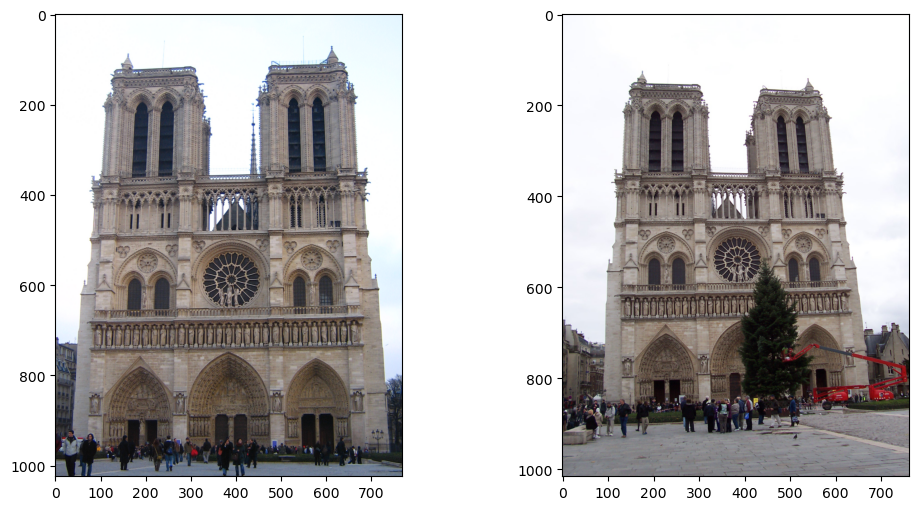

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Any, Callable, List, Tuple
import torch
import torch.nn as nn

from pa2_code.utils import load_image, PIL_resize, rgb2gray, normalize_img, verify, save_image
from IPython.core.debugger import set_trace

# Notre Dame
image1 = load_image('../data/1a_notredame.jpg')
image2 = load_image('../data/1b_notredame.jpg')
eval_file = '../ground_truth/notredame.pkl'

# Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
# image1 = load_image('../data/2a_rushmore.jpg')
# image2 = load_image('../data/2b_rushmore.jpg')
# eval_file = '../ground_truth/rushmore.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
# image1 = load_image('../data/3a_gaudi.jpg')
# image2 = load_image('../data/3b_gaudi.jpg')
# eval_file = '../ground_truth/gaudi.pkl'

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))

image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

# Programming assignment starts here

## Potentially useful NumPy and OpenCV functions
<font size='4'>From Numpy: `np.argsort(), np.arctan2(), np.concatenate(), np.fliplr(), np.flipud(), np.histogram(), np.hypot(), np.linalg.norm(), np.linspace(), np.newaxis, np.reshape(), np.sort()`.</font>

<font size='4'>Please use `cv2.filter2D` for image filtering/convolution. Its documentation can be found [here](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/group_imgproc_filter.html#doxid-d4-d86-group-imgproc-filter-1ga27c049795ce870216ddfb366086b5a04)

## Forbidden functions
<font size='4'>You can use these OpenCV, Sci-kit Image, and SciPy functions for testing, but not in your final code). `cv2. getGaussianKernel(),np.gradient(), cv2.Sobel(), cv2.SIFT(), cv2.SURF(), cv2.BFMatcher(), cv2.BFMatcher ().match(), cv2.BFMatcher().knnMatch(), cv2.FlannBasedMatcher().knnMatch(), cv2.HOGDescriptor(), cv2. cornerHarris(), cv2.FastFeatureDetector(), cv2.ORB(), skimage.feature, skimage.feature.hog(), skimage. feature.daisy, skimage.feature.corner_harris(), skimage.feature.corner_shi_tomasi(), skimage.feature .match_descriptors(), skimage.feature.ORB(), cv.filter2D(), scipy.signal.convolve()`.
    
<font size='4'>We haven’t enumerated all possible forbidden functions here, but using anyone else’s code that performs interest point detection, feature computation, or feature matching for you is forbidden.

## Part 1: Interest point detection

<img src='meta_data/interest_point_detection.png' height='1200'/>

<font size='4'>You do not need to worry about scale invariance or keypoint orientation estimation for your baseline Harris corner detector. The original paper by Chris Harris and Mike Stephens describing their corner detector can be found [here](http://www.bmva.org/bmvc/1988/avc-88-023.pdf).

<font size="4" color="red">**task 1.1: Compute image gradients using the Sobel filter.**</font><br><br>

In [3]:
SOBEL_X_KERNEL = np.array(
    [
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]).astype(np.float32)

SOBEL_Y_KERNEL = np.array(
    [
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ]).astype(np.float32)


def compute_image_gradients(image_bw: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Use convolution with Sobel filters to compute the image gradient at each
    pixel.

    Args:
        image_bw: A numpy array of shape (M,N) containing the grayscale image

    Returns:
        Ix: Array of shape (M,N) representing partial derivatives of image
            w.r.t. x-direction
        Iy: Array of shape (M,N) representing partial derivative of image
            w.r.t. y-direction
    """

    img_padding = np.pad(image_bw, [(1, 1), (1, 1)], mode='constant')
    
    Ix = cv2.filter2D(img_padding, -1, SOBEL_X_KERNEL)
    Iy = cv2.filter2D(img_padding, -1, SOBEL_Y_KERNEL)
    Ix, Iy = Ix[1:-1, 1:-1], Iy[1:-1, 1:-1]

    return Ix, Iy

compute_image_gradients():  "Correct"


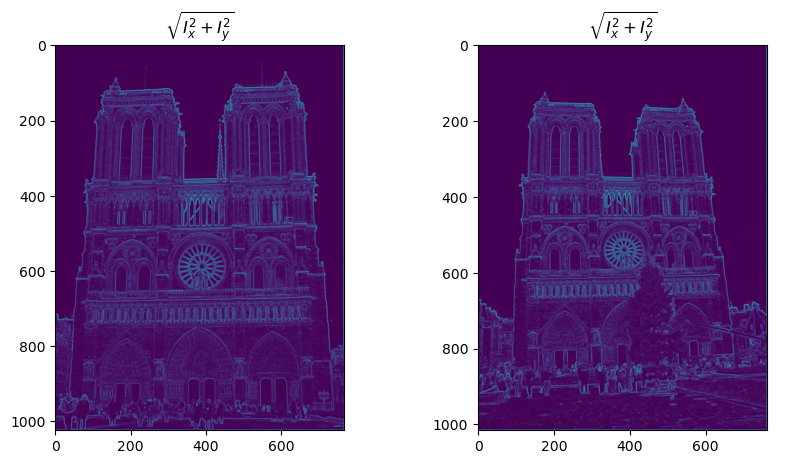

In [4]:
# Let's check your implementation
from pa2_unit_tests.test_part1_harris_corner import test_compute_image_gradients

print('compute_image_gradients(): ', verify(test_compute_image_gradients(compute_image_gradients)))

plt.figure(figsize=(10,5))
plt.axis('off')

Ix, Iy = compute_image_gradients(image1_bw)
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,1)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))

Ix, Iy = compute_image_gradients(image2_bw)
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,2)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))

<font size="4" color="red">**task 1.2: Create a 2D Gaussian kernel.**</font><br><br>

In [5]:
def get_gaussian_kernel_2D(ksize: int, sigma: float) -> np.ndarray:
    """Create a numpy matrix representing a 2d Gaussian kernel

    Args:
        ksize: dimension of square kernel
        sigma: standard deviation of Gaussian

    Returns:
        kernel: Array of shape (ksize,ksize) representing a 2d Gaussian kernel
    """
    
    ax = np.linspace(-(ksize - 1) / 2, (ksize - 1) / 2, ksize)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    kernel /= np.sum(kernel)

    return kernel

In [6]:
# Let's check your implementation
from pa2_unit_tests.test_part1_harris_corner import (
    test_get_gaussian_kernel_2D_peak,
    test_get_gaussian_kernel_2D_sumsto1,
    test_get_gaussian_kernel_2D,
    test_second_moments
)

print(
    'get_gaussian_kernel_2D_peak():', 
    verify(test_get_gaussian_kernel_2D_peak(get_gaussian_kernel_2D))
)
print(
    'get_gaussian_kernel_2D_sumsto1():', 
    verify(test_get_gaussian_kernel_2D_sumsto1(get_gaussian_kernel_2D))
)
print(
    'get_gaussian_kernel_2D():', 
    verify(test_get_gaussian_kernel_2D(get_gaussian_kernel_2D))
)

get_gaussian_kernel_2D_peak(): "Correct"
get_gaussian_kernel_2D_sumsto1(): "Correct"
get_gaussian_kernel_2D(): "Correct"


<font size="4" color="red">**task 1.3: Compute the second moments of the input image. You will need to use your
`get_gaussian_kernel_2D()` method.**</font><br><br>

In [7]:
def second_moments(
    image_bw: np.ndarray,
    ksize: int = 7,
    sigma: float = 10
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Compute second moments from image.

    Compute image gradients Ix and Iy at each pixel, the mixed derivatives,
    then the second moments (sx2, sxsy, sy2) at each pixel, using convolution
    with a Gaussian filter.

    Args:
        image_bw: array of shape (M,N) containing the grayscale image
        ksize: size of 2d Gaussian filter
        sigma: standard deviation of Gaussian filter

    Returns:
        sx2: array of shape (M,N) containing the second moment in x direction
        sy2: array of shape (M,N) containing the second moment in y direction
        sxsy: array of dim (M,N) containing the second moment in the x then the
            y direction
    """

    sx2, sy2, sxsy = None, None, None


    Ix, Iy = compute_image_gradients(image_bw)

    l = (ksize - 1) // 2
    Ix = np.pad(Ix, [(l, l), (l, l)], mode='constant')
    Iy = np.pad(Iy, [(l, l), (l, l)], mode='constant')
    
    Ix2, Iy2 = Ix**2, Iy**2
    
    IxIy = Ix * Iy
    
    g_kernel = get_gaussian_kernel_2D(ksize, sigma)
    
    sx2 = cv2.filter2D(Ix2, -1, g_kernel) 
    sy2 = cv2.filter2D(Iy2, -1, g_kernel) 
    sxsy = cv2.filter2D(IxIy, -1, g_kernel)
    
    sx2 = sx2[l:-l, l:-l]
    sy2 = sy2[l:-l, l:-l]
    sxsy = sxsy[l:-l, l:-l]

    return sx2, sy2, sxsy

second_moments(): "Correct"


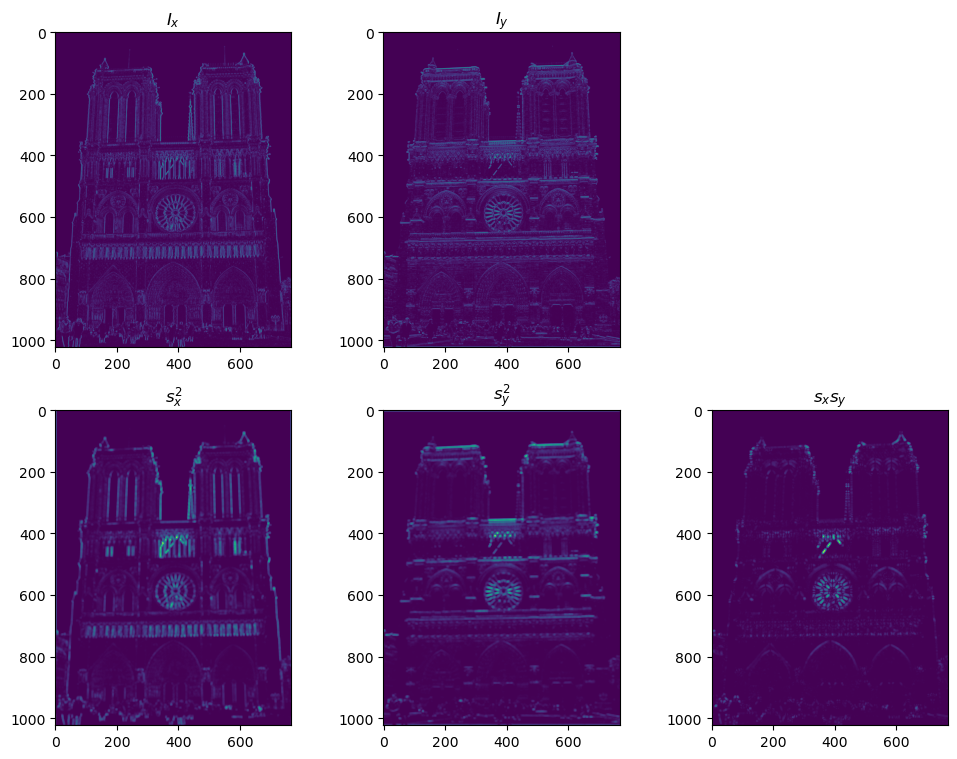

In [8]:
# Let's check your implementation
from pa2_code.utils import normalize_img

print('second_moments():', verify(test_second_moments(second_moments)))

sx2, sy2, sxsy = second_moments(image1_bw, ksize = 7, sigma = 10)

plt.figure(figsize=(12,9))
Ix, Iy = compute_image_gradients(image1_bw)
plt.subplot(2,3,1); plt.title(r'$I_x$')
plt.imshow( (normalize_img(np.abs(Ix))*255).astype(np.uint8))
plt.subplot(2,3,2); plt.title(r'$I_y$')
plt.imshow( (normalize_img(np.abs(Iy))*255).astype(np.uint8))

plt.subplot(2,3,4)
plt.title(r'$s_x^2$')
plt.imshow( (normalize_img(np.abs(sx2))*255).astype(np.uint8))

plt.subplot(2,3,5)
plt.title(r'$s_y^2$')
plt.imshow( (normalize_img(np.abs(sy2))*255).astype(np.uint8))

plt.subplot(2,3,6)
plt.title(r'$s_xs_y$')
plt.imshow( (normalize_img(np.abs(sxsy))*255).astype(np.uint8))

<font size="4" color="red">**task 1.4: Get the raw corner responses over the entire image (the previously
implemented methods may be helpful).**</font><br><br>

In [9]:
def compute_harris_response_map(
    image_bw: np.ndarray,
    ksize: int = 7,
    sigma: float = 5,
    alpha: float = 0.05
) -> np.ndarray:
    """Compute the Harris cornerness score at each pixel (See Szeliski 7.1.1)

    Recall that R = det(M) - alpha * (trace(M))^2
    where M = [S_xx S_xy;
               S_xy  S_yy],
          S_xx = Gk * I_xx
          S_yy = Gk * I_yy
          S_xy  = Gk * I_xy,
    and * is a convolutional operation over a Gaussian kernel of size (k, k).
    (You can verify that this is equivalent to taking a (Gaussian) weighted sum
    over the window of size (k, k), see how convolutional operation works here:
        http://cs231n.github.io/convolutional-networks/)

    Ix, Iy are simply image derivatives in x and y directions, respectively.

    Args:
        image_bw: array of shape (M,N) containing the grayscale image
            ksize: size of 2d Gaussian filter
        sigma: standard deviation of gaussian filter
        alpha: scalar term in Harris response score

    Returns:
        R: array of shape (M,N), indicating the corner score of each pixel.
    """

    sx2, sy2, sxsy = second_moments(image_bw, ksize, sigma)
    
    R = sx2 * sy2 - sxsy**2 - alpha * (sx2 + sy2)**2

    return R

compute_harris_response_map():  "Correct"


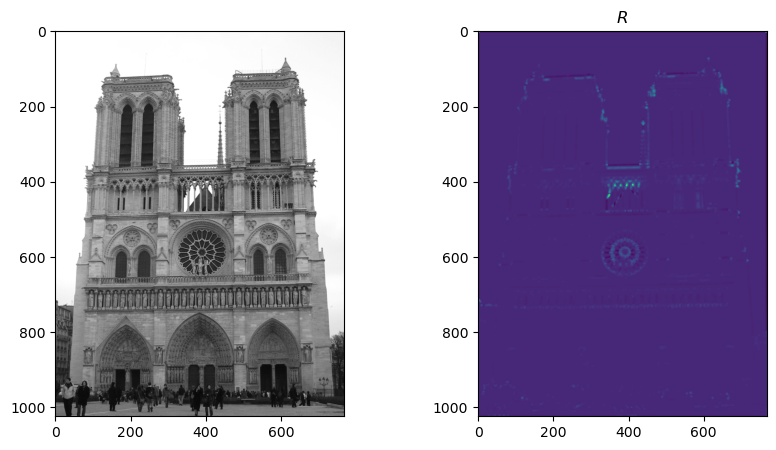

In [10]:
# Let's check your implementation
from pa2_unit_tests.test_part1_harris_corner import test_compute_harris_response_map

print(
    'compute_harris_response_map(): ', 
    verify(test_compute_harris_response_map(compute_harris_response_map)))

R = compute_harris_response_map(image1_bw)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image1_bw, cmap='gray')
plt.subplot(1,2,2)
plt.title(r'$R$')
plt.imshow(R)

<font size="4" color="red">**task 1.5: Performs the maxpooling operation using PyTorch.**</font><br><br>

In [11]:
def nms_maxpool_pytorch(R: np.ndarray, ksize: int=7, k: int=2000) -> np.ndarray:
    """ Get top k interest points that are local maxima over (ksize,ksize)
    neighborhood.
    
    HINT: One simple way to do non-maximum suppression is to simply pick a
    local maximum over some window size (u, v). This can be achieved using
    nn.functional.max_pool2d (or nn.MaxPool2d). Note that this would give 
    us all local maxima even when they have a really low score compare to 
    other local maxima. It might be useful to threshold out low value score 
    before doing the pooling (torch.median or np.median might be useful here).

    You will definitely need to understand how nn.MaxPool2d works in order to
    utilize it, see https://pytorch.org/docs/stable/nn.html#maxpool2d

    Threshold globally everything below the median to zero, and then
    MaxPool over a 7x7 kernel. This will fill every entry in the subgrids
    with the maximum nearby value. Binarize the image according to
    locations that are equal to their maximum. Multiply this binary
    image, multiplied with the cornerness response values. We'll be testing
    only 1 image at a time.

    Args:
        R: score response map of shape (M,N)
        ksize: kernel size of max-pooling operator
        k: number of interest points (take top k by confidence)

    Returns:
        x: array of shape (k,) containing x-coordinates of interest points
        y: array of shape (k,) containing y-coordinates of interest points
        c: array of shape (k,) containing confidences of interest points
        
    More hints:
    - We encourage you to try implementing this naively first, just be aware
      that it may take an absurdly long time to run. You will need to get a
      function that takes a reasonable amount of time to run so that the TAs
      can verify your code works.
    - If you need to apply padding to the image, only use the zero-padding
      method. You need to compute how much padding is required, if any.
    - "Stride" should be set to 1 in your implementation.
    """
    
    x, y, confidences = None, None, None

    
    median = np.median(R)
    R[R < median] = 0
    
    l = (ksize - 1) // 2
    
    R_pad = np.pad(R, [(l, l), (l, l)], mode='constant', constant_values=-np.inf)
    
    m = nn.MaxPool2d((ksize, ksize), stride=1)

    R_tensor = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(R_pad), 0), 0)
    R_out = m(R_tensor).numpy()[0][0]
    
    y, x = np.where(R == R_out)
    confidences = R[y, x]

    confidences_args = confidences.argsort()[::-1]
    x, y = x[confidences_args], y[confidences_args]
    
    x, y = x[:min(x.shape[0], k)], y[:min(y.shape[0], k)]
    confidences = confidences[confidences_args]
    confidences = confidences[:min(confidences.shape[0], k)]


    return x, y, confidences

nms_maxpool():  "Correct"
Coordinates of local maxima:
	At 3,3, local maximum w/ confidence=7.00
	At 1,1, local maximum w/ confidence=6.00


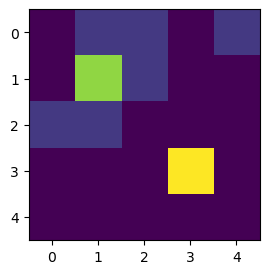

In [12]:
# Let's check your implementation
from pa2_unit_tests.test_part1_harris_corner import test_nms_maxpool
from pa2_code.utils import verify

print('nms_maxpool(): ', verify(test_nms_maxpool(nms_maxpool_pytorch)))

toy_response_map = np.array(
[
    [1,2,2,1,2],
    [1,6,2,1,1],
    [2,2,1,1,1],
    [1,1,1,7,1],
    [1,1,1,1,1]
]).astype(np.float32)
plt.figure(figsize=(6,3))
plt.imshow(toy_response_map.astype(np.uint8))

x_coords, y_coords, confidences = nms_maxpool_pytorch(toy_response_map, k=2, ksize=3)
print('Coordinates of local maxima:')
for x, y, c in zip(x_coords, y_coords, confidences):
    print(f'\tAt {x},{y}, local maximum w/ confidence={c:.2f}')

<font size="4" color="Blue">**Extra credit: 1.5.1: Performs the maxpooling operation without using PyTorch.**</font><br><br>
<font size="4" color="Blue">**Note: to get the full credit, you need to get a function that takes a reasonable amount of time to run so that the TAs can verify your code works.**</font><br><br>

In [13]:
def nms_maxpool_no_pytorch(R: np.ndarray, ksize: int, k: int) -> np.ndarray:
    """ Get top k interest points that are local maxima over (ksize,ksize)
    neighborhood.
    
    HINT: One simple way to do non-maximum suppression is to simply pick a
    local maximum over some window size (u, v). Note that this would give 
    us all local maxima even when they have a really low score compare to 
    other local maxima. It might be useful to threshold out low value score 
    before doing the pooling (np.median might be useful here).

    Threshold globally everything below the median to zero, and then
    MaxPool over a 7x7 kernel. This will fill every entry in the subgrids
    with the maximum nearby value. Binarize the image according to
    locations that are equal to their maximum. Multiply this binary
    image, multiplied with the cornerness response values. We'll be testing
    only 1 image at a time.
    
    HINT2: While most feature detectors simply look for local maxima in the 
    interest function, this can lead to an uneven distribution of feature 
    points across the image, e.g., points will be denser in regions of higher
    contrast. To mitigate this problem, Brown, Szeliski, and Winder (2005) 
    only detect features that are both local maxima and whose response value 
    is significantly (10%) greater than that of all of its neighbors within a 
    radius r. The goal is to retain only those points that are a maximum in a
    neighborhood of radius r pixels. One way to do so is to sort all points by
    the response strength, from large to small response. The first entry in the
    list is the global maximum, which is not suppressed at any radius. Then, we
    can iterate through the list and compute the distance to each interest point
    ahead of it in the list (these are pixels with even greater response strength).
    The minimum of distances to a keypoint's stronger neighbors (multiplying 
    these neighbors by >=1.1 to add robustness) is the radius within which the 
    current point is a local maximum. We call this the suppression radius of this
    interest point, and we save these suppression radii. Finally, we sort the 
    suppression radii from large to small, and return the n keypoints associated
    with the top n suppression radii, in this sorted orderself. Feel free to 
    experiment with n, we used n=15000.
    See:                                                                     
        https://www.microsoft.com/en-us/research/wp-content/uploads/2005/06/cvpr05.pdf
    or                                                                       
        https://www.cs.ucsb.edu/~holl/pubs/Gauglitz-2011-ICIP.pdf           

    Args:
        R: score response map of shape (M,N)
        ksize: kernel size of max-pooling operator
        k: number of interest points (take top k by confidence)

    Returns:
        x: array of shape (k,) containing x-coordinates of interest points
        y: array of shape (k,) containing y-coordinates of interest points
        c: array of shape (k,) containing confidences of interest points
        
    More hints:
    - If you need to apply padding to the image, only use the zero-padding
      method. You need to compute how much padding is required, if any.
    - "Stride" should be set to 1 in your implementation.
    """
    
    x, y, confidences = None, None, None
    
    from collections import defaultdict
    from numpy.lib.stride_tricks import as_strided
    
    median = np.median(R)
    R[R < median] = 0
    
    l = (ksize - 1) // 2
    R_pad = np.pad(R, [(l, l), (l, l)], mode='constant', constant_values=-np.inf)
    stride = 1
    
    output_shape = ((R_pad.shape[0] - ksize) // stride + 1, (R_pad.shape[1] - ksize) // stride + 1)
    shape_w = (output_shape[0], output_shape[1], ksize, ksize)
    strides_w = (stride * R_pad.strides[0], stride * R_pad.strides[1], R_pad.strides[0], R_pad.strides[1])
    R_w = as_strided(R_pad, shape_w, strides_w)
    R_out = R_w.max(axis=(2, 3))
    
    y, x = np.where(R == R_out)
    confidences = R[y, x]

    confidences_args = confidences.argsort()[::-1]
    x, y = x[confidences_args], y[confidences_args]
    x, y = x[:min(x.shape[0], k)], y[:min(y.shape[0], k)]
    confidences = confidences[confidences_args]
    confidences = confidences[:min(confidences.shape[0], k)]
    
    return x, y, confidences

<font size="4" color="red">**task 1.6: Remove values close to the border that we can’t create a useful SIFT window around.**</font><br><br>

In [14]:
def remove_border_vals(
    img: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    c: np.ndarray
) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """
    Remove interest points that are too close to a border to allow SIFT feature
    extraction. Make sure you remove all points where a 16x16 window around
    that point cannot be formed.

    Args:
        img: array of shape (M,N) containing the grayscale image
        x: array of shape (k,) representing x coord of interest points
        y: array of shape (k,) representing y coord of interest points
        c: array of shape (k,) representing confidences of interest points

    Returns:
        x: array of shape (p,), where p <= k (less than or equal after pruning)
        y: array of shape (p,)
        c: array of shape (p,)
    """

    m, n = img.shape
    k = x.shape[0]
    b = np.array([True] * k)
    
    mask = np.logical_or(np.logical_and(x > -1, x < 7), np.logical_and(x >= (n - 8), x < n))
    mask = np.logical_or(mask, np.logical_or(np.logical_and(y > -1, y < 7), np.logical_and(y >= (m - 8), y < m)))
    b[mask] = False
    
    x, y, c = x[b], y[b], c[b]

    return x, y, c

In [15]:
# Let's check your implementation
from pa2_unit_tests.test_part1_harris_corner import test_get_harris_interest_points, test_remove_border_vals

print(
    'test_remove_border_vals(): ', 
    verify(test_remove_border_vals(remove_border_vals))
)

test_remove_border_vals():  "Correct"


<font size="4" color="red">**task 1.7: Get interests points from the entire image (the previously imple- mented methods may be helpful).**</font><br><br>

In [16]:
def get_harris_interest_points(
    image_bw: np.ndarray,
    k: int = 2500
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Implement the Harris Corner detector. You will find
    compute_harris_response_map(), nms_maxpool_numpy(), and
    remove_border_vals() useful. Make sure to sort the interest points in
    order of confidence!

    Args:
        image_bw: array of shape (M,N) containing the grayscale image
        k: maximum number of interest points to retrieve

    Returns:
        x: array of shape (p,) containing x-coordinates of interest points
        y: array of shape (p,) containing y-coordinates of interest points
        c: array of dim (p,) containing the strength(confidence) of each
            interest point where p <= k.
    """


    R = compute_harris_response_map(image_bw)
    x, y, c = nms_maxpool_pytorch(R, 7, k)
    x, y, c = remove_border_vals(image_bw, x, y, c)

    
    return x, y, c

get_harris_interest_points() "Correct"
2464 corners in image 1, 2455 corners in image 2


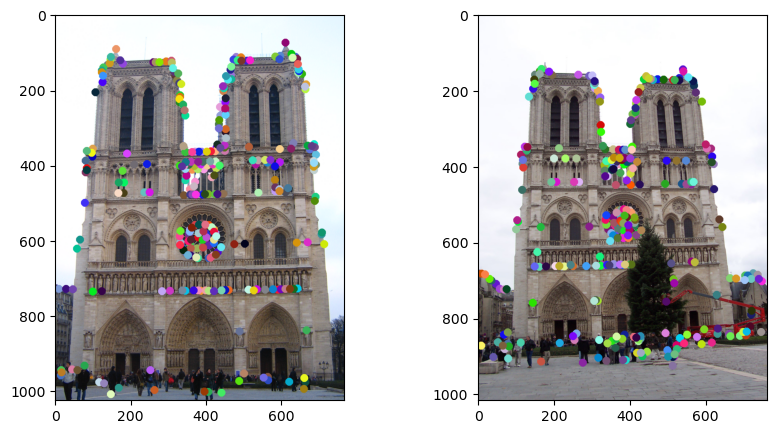

In [17]:
# Let's check your implementation
print(
    'get_harris_interest_points()', 
    verify(test_get_harris_interest_points(get_harris_interest_points))
)

import copy
from pa2_code.utils import show_interest_points

num_interest_points = 2500
X1, Y1, _ = get_harris_interest_points( copy.deepcopy(image1_bw), num_interest_points)
X2, Y2, _ = get_harris_interest_points( copy.deepcopy(image2_bw), num_interest_points)

num_pts_to_visualize = 300
# Visualize the interest points
rendered_img1 = show_interest_points(image1, X1[:num_pts_to_visualize], Y1[:num_pts_to_visualize])
rendered_img2 = show_interest_points(image2, X2[:num_pts_to_visualize], Y2[:num_pts_to_visualize])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rendered_img1)
plt.subplot(1,2,2); plt.imshow(rendered_img2)
print(f'{len(X1)} corners in image 1, {len(X2)} corners in image 2')

## Part 2: Local feature descriptors

<font size='4'>To get your matching pipeline working quickly, you will implement a bare-bones feature descriptor using normalized, grayscale image intensity patches as your local feature. See Szeliski 7.1.2 for more details.
    
<font size='4'>Choose the top-left option of the 4 possible choices for center of a square window, as shown in the Figure below.

<img src='meta_data/window.png' height='1200'/>
<font size='4'>For this example of a 6 × 6 window, the yellow cells could all be considered the center. Please choose the top left (marked “C”) as the center throughout this assignment.

<font size="4" color="red">**task 2: Implement a bare-bones feature descriptor using normalized, grayscale image intensity patches as your local feature.**</font><br><br>

In [18]:
def compute_normalized_patch_descriptors(
    image_bw: np.ndarray, X: float, Y: float, feature_width: int
) -> np.ndarray:
    """Create local features using normalized patches.

    Normalize image intensities in a local window centered at keypoint to a
    feature vector with unit norm. This local feature is simple to code and
    works OK.

    Choose the top-left option of the 4 possible choices for center of a square
    window.

    Args:
        image_bw: array of shape (M,N) representing grayscale image
        X: array of shape (K,) representing x-coordinate of keypoints
        Y: array of shape (K,) representing y-coordinate of keypoints
        feature_width: size of the square window

    Returns:
        fvs: array of shape (K,D) representing feature descriptors
    """

    fvs = np.zeros((X.shape[0], feature_width*feature_width))
    
    l = feature_width // 2

    adjustment = 1 - (feature_width % 2)
    
    for idx, v in enumerate(zip(X, Y)):
        f_vec = image_bw[(v[1]-l+1): (v[1]+l+adjustment), (v[0]-l+1): (v[0]+l+adjustment)]
        f_vec = f_vec / np.linalg.norm(f_vec)
        fvs[idx] = np.ndarray.flatten(f_vec)

    return fvs

compute_normalized_patch_descriptors: "Correct"


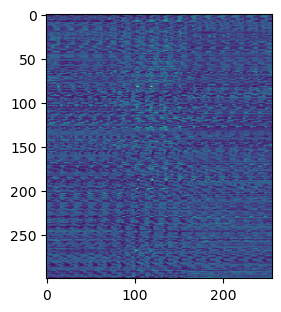

In [19]:
# Let's check your implementation
from pa2_unit_tests.test_part2_patch_descriptor import test_compute_normalized_patch_descriptors

print(
    'compute_normalized_patch_descriptors:', 
    verify(test_compute_normalized_patch_descriptors(compute_normalized_patch_descriptors))
)

image1_features = compute_normalized_patch_descriptors(image1_bw, X1, Y1, feature_width=16)
image2_features = compute_normalized_patch_descriptors(image2_bw, X2, Y2, feature_width=16)

# Visualize what the first 300 feature vectors for image 1 look like (they should not be identical or all black)
plt.figure()
plt.subplot(1,2,1); plt.imshow(image1_features[:300])

## Part 3: Feature matching

<font size='4'>You will implement the “ratio test” (also known as the “nearest neighbor distance ratio test”) method of matching local features as described in the lecture materials and Szeliski 7.1.3 (page 421). See equation 7.18 in particular. The potential matches that pass the ratio test the easiest should have a greater tendency to be correct matches – think about why this is. 
    
In this part, you will have to code `compute_feature_distances()` to get pairwise feature distances, and `match_features_ratio_test()` to perform the ratio test to get matches from a pair of feature lists.

<font size="4" color="red">**task 3.1: Get pairwise feature distances.**</font><br><br>

In [20]:
def compute_feature_distances(
    features1: np.ndarray,
    features2: np.ndarray
) -> np.ndarray:
    """
    This function computes a list of distances from every feature in one array
    to every feature in another.

    Using Numpy broadcasting is required to keep memory requirements low.

    Note: Using a double for-loop is going to be too slow. One for-loop is the
    maximum possible. Vectorization is needed.
    See numpy broadcasting details here:
        https://cs231n.github.io/python-numpy-tutorial/#broadcasting

    Args:
        features1: A numpy array of shape (n1,feat_dim) representing one set of
            features, where feat_dim denotes the feature dimensionality
        features2: A numpy array of shape (n2,feat_dim) representing a second
            set of features (n1 not necessarily equal to n2)

    Returns:
        dists: A numpy array of shape (n1,n2) which holds the distances (in
            feature space) from each feature in features1 to each feature in
            features2
    """
    dists = []
    for feature in features1:
        dists.append(np.linalg.norm(features2 - feature, axis=1))
    
    dists = np.array(dists)

    return dists

In [21]:
# Let's check your implementation
from pa2_unit_tests.test_part3_feature_matching import (
    test_match_features_ratio_test,
    test_compute_feature_distances_2d,
    test_compute_feature_distances_10d
)
print(
    'compute_feature_distances (2d):', 
    verify(test_compute_feature_distances_2d(compute_feature_distances))
)

print(
    'compute_feature_distances (10d):', 
    verify(test_compute_feature_distances_10d(compute_feature_distances))
)

compute_feature_distances (2d): "Correct"
compute_feature_distances (10d): "Correct"


<font size="4" color="red">**task 3.2: Perform the ratio test to get matches from a pair of feature lists.**</font><br><br>

In [22]:
def match_features_ratio_test(
    features1: np.ndarray,
    features2: np.ndarray,
    ratio_thresh: float = 0.8
) -> Tuple[np.ndarray, np.ndarray]:
    """ Nearest-neighbor distance ratio feature matching.

    This function does not need to be symmetric (e.g. it can produce different
    numbers of matches depending on the order of the arguments).

    To start with, simply implement the "ratio test", equation 7.18 in section
    7.1.3 of Szeliski. There are a lot of repetitive features in these images,
    and all of their descriptors will look similar. The ratio test helps us
    resolve this issue (also see Figure 11 of David Lowe's IJCV paper).

    You should call `compute_feature_distances()` in this function, and then
    process the output.

    Args:
        features1: A numpy array of shape (n1,feat_dim) representing one set of
            features, where feat_dim denotes the feature dimensionality
        features2: A numpy array of shape (n2,feat_dim) representing a second
            set of features (n1 not necessarily equal to n2)

    Returns:
        matches: A numpy array of shape (k,2), where k is the number of matches.
            The first column is an index in features1, and the second column is
            an index in features2
        confidences: A numpy array of shape (k,) with the real valued confidence
            for every match

    'matches' and 'confidences' can be empty, e.g., (0x2) and (0x1)
    """
    def get_match_point(dist, i):
        top2_ind = np.argpartition(dist, 1)[:2]
        top2 = dist[top2_ind]
        if top2[0] < top2[1]:
            r = top2[0] / top2[1]
            match_index = top2_ind[0]
        else:
            r = top2[1] / top2[0]
            match_index = top2_ind[1]
        if r <= ratio_thresh:
            return np.array([i, match_index, r])
        return np.array([-1, -1, -1])
    
    dists = compute_feature_distances(features1, features2)
    
    match_points = np.array([get_match_point(dist, i) for i, dist in enumerate(dists)])
    match_points = match_points[match_points != np.array([-1, -1, -1])]
    match_points = match_points.reshape(match_points.shape[0] // 3, 3)

    sorted_match_points = match_points[match_points[:, 2].argsort()]
    matches = sorted_match_points[:, [0, 1]].astype(int)
    confidences = sorted_match_points[:, 2]
    
    
    return matches, confidences

In [23]:
# Let's check your implementation
print(
    'match_features_ratio_test:', 
    verify(test_match_features_ratio_test(match_features_ratio_test))
)

matches, confidences = match_features_ratio_test(image1_features, image2_features)
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

match_features_ratio_test: "Correct"
105 matches from 2464 corners


## Part 4: SIFT Descriptor

<font size='4'>You will implement a SIFT-like local feature as described in the lecture materials and Szeliski 7.1.2. We’ll use a simple one-line modification (“Square-Root SIFT”) from a 2012 [CVPR paper](https://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf) to get a free boost in performance. 
    
<font size='4'>Regarding Histograms SIFT relies upon histograms. An unweighted 1D histogram with 3 bins could have bin edges of $[0,2,4,6]$. If $x = [0.0,0.1,2.5,5.8,5.9]$, and the bins are defined over half-open intervals $[e_{left},e_{right})$ with edges $e$, then the histogram $h = [2,1,2]$.
    
<font size='4'>A weighted 1D histogram with the same 3 bins and bin edges has each item weighted by some value. For example, for an array $x = [0.0, 0.1, 2.5, 5.8, 5.9]$, with weights $w = [2, 3, 1, 0, 0]$, and the same bin edges ($[0, 2, 4, 6]), h_w = [5, 1, 0]$. In SIFT, the histogram weight at a pixel is the magnitude of the image gradient at that pixel.

<font size="4" color="red">**task 4.1: Retrieve gradient magnitudes and orientations of the image.**</font><br><br>

In [24]:
def get_magnitudes_and_orientations(
    Ix: np.ndarray,
    Iy: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function will return the magnitudes and orientations of the
    gradients at each pixel location.

    Args:
        Ix: array of shape (m,n), representing x gradients in the image
        Iy: array of shape (m,n), representing y gradients in the image
    Returns:
        magnitudes: A numpy array of shape (m,n), representing magnitudes of
            the gradients at each pixel location
        orientations: A numpy array of shape (m,n), representing angles of
            the gradients at each pixel location. angles should range from
            -PI to PI.
    """
    magnitudes = []
    orientations = []


    magnitudes = np.sqrt(Ix**2 + Iy**2)
    orientations = np.arctan2(Iy, Ix)
    
    return magnitudes, orientations

In [25]:
# Let's check your implementation
from pa2_unit_tests.test_part4_sift_descriptor import (
    test_get_magnitudes_and_orientations,
    test_get_gradient_histogram_vec_from_patch
)
print(
    'get_magnitudes_and_orientations:', 
    verify(test_get_magnitudes_and_orientations(get_magnitudes_and_orientations))
)

get_magnitudes_and_orientations: "Correct"


<font size="4" color="red">**task 4.2: Retrieve a feature consisting of concatenated histograms.**</font><br><br>

In [26]:
def get_gradient_histogram_vec_from_patch(
    window_magnitudes: np.ndarray,
    window_orientations: np.ndarray
) -> np.ndarray:
    """ Given 16x16 patch, form a 128-d vector of gradient histograms.

    Key properties to implement:
    (1) a 4x4 grid of cells, each feature_width/4. It is simply the terminology
        used in the feature literature to describe the spatial bins where
        gradient distributions will be described. The grid will extend
        feature_width/2 to the left of the "center", and feature_width/2 - 1 to
        the right
    (2) each cell should have a histogram of the local distribution of
        gradients in 8 orientations. Appending these histograms together will
        give you 4x4 x 8 = 128 dimensions. The bin centers for the histogram
        should be at -7pi/8,-5pi/8,...5pi/8,7pi/8. The histograms should be
        added to the feature vector left to right then row by row (reading
        order).

    Do not normalize the histogram here to unit norm -- preserve the histogram
    values. A useful function to look at would be np.histogram.

    Args:
        window_magnitudes: (16,16) array representing gradient magnitudes of the
            patch
        window_orientations: (16,16) array representing gradient orientations of
            the patch

    Returns:
        wgh: (128,1) representing weighted gradient histograms for all 16
            neighborhoods of size 4x4 px
    """

    histogram = np.zeros((4, 4, 8))
    pi = np.pi
    hist_bin_edges = [k * pi / 4 for k in range(-4, 5)]
    
    for i in range(0, window_magnitudes.shape[0], 4):
        for j in range(0, window_orientations.shape[0], 4):
            weights, bins = np.histogram(window_orientations[i: (i + 4), j: (j + 4)].flatten(), bins=hist_bin_edges, weights=window_magnitudes[i: (i + 4), j: (j + 4)].flatten())
            histogram[i // 4][j // 4] = weights
    
    FeatureVectorIn = histogram.reshape((128, -1))


    return FeatureVectorIn

In [27]:
# Let's check your implementation
print(
    'get_gradient_histogram_vec_from_patch():', 
    verify(test_get_gradient_histogram_vec_from_patch(get_gradient_histogram_vec_from_patch))
)

get_gradient_histogram_vec_from_patch(): "Correct"


<font size="4" color="red">**task 4.3: Get the adjusted feature from a single point.**</font><br><br>

In [28]:
def get_feat_vec(
    x: float,
    y: float,
    magnitudes,
    orientations,
    feature_width: int = 16
) -> np.ndarray:
    """
    This function returns the feature vector for a specific interest point. 
    Your implementation does not need to exactly match the SIFT reference.


    Specifically, your descriptor should have:
    (1) Each feature should be normalized to unit length.
    (2) Each feature should be raised to the 1/2 power, i.e., square-root SIFT
        (read https://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf)

    For our tests, you do not need to perform the interpolation in which each
    gradient measurement contributes to multiple orientation bins in multiple
    cells. As described in Szeliski, a single gradient measurement creates a
    weighted contribution to the 4 nearest cells and the 2 nearest orientation
    bins within each cell, for 8 total contributions. The autograder will only
    check for each gradient contributing to a single bin.

    Args:
        x: a float, the x-coordinate of the interest point
        y: A float, the y-coordinate of the interest point
        magnitudes: A numpy array of shape (m,n), representing image gradients
            at each pixel location
        orientations: A numpy array of shape (m,n), representing gradient
            orientations at each pixel location
        feature_width: integer representing the local feature width in pixels.
            You can assume that feature_width will be a multiple of 4 (i.e.,
            every cell of your local SIFT-like feature will have an integer
            width and height). This is the initial window size we examine
            around each keypoint.
    Returns:
        fv: A numpy array of shape (feat_dim,1) representing a feature vector.
            "feat_dim" is the feature_dimensionality (e.g., 128 for standard
            SIFT). These are the computed features.
    """

    fv = []


    window_magnitudes = magnitudes[y + 1 - feature_width // 2: y + 1 + feature_width // 2, x + 1 - feature_width // 2: x + 1 + feature_width // 2]
    window_orientations = orientations[y + 1 - feature_width // 2: y + 1 + feature_width // 2, x + 1 - feature_width // 2: x + 1 + feature_width // 2]
    
    fv = get_gradient_histogram_vec_from_patch(window_magnitudes, window_orientations)
    fv = fv / np.linalg.norm(fv)
    fv = np.sqrt(fv)


    return fv

In [29]:
# Let's check your implementation
from pa2_unit_tests.test_part4_sift_descriptor import test_get_feat_vec, test_get_SIFT_descriptors
print(verify(test_get_feat_vec(get_feat_vec)))

"Correct"


<font size="4" color="red">**task 4.4: Get all feature vectors corresponding to our interest points from an image.**</font><br><br>

In [30]:
def get_SIFT_descriptors(
    image_bw: np.ndarray,
    X: np.ndarray,
    Y: np.ndarray,
    feature_width: int = 16
) -> np.ndarray:
    """
    This function returns the 128-d SIFT features computed at each of the input
    points. Implement a simple version without soft binning, gaussian filtering
    of the magnitudes, etc. If you have done them, put them into the extra 
    credit part.

    Args:
        image: A numpy array of shape (m,n), the image
        X: A numpy array of shape (k,), the x-coordinates of interest points
        Y: A numpy array of shape (k,), the y-coordinates of interest points
        feature_width: integer representing the local feature width in pixels.
            You can assume that feature_width will be a multiple of 4 (i.e.,
            every cell of your local SIFT-like feature will have an integer
            width and height). This is the initial window size we examine
            around each keypoint.
    Returns:
        fvs: A numpy array of shape (k, feat_dim) representing all feature
            vectors. "feat_dim" is the feature_dimensionality (e.g., 128 for
            standard SIFT). These are the computed features.
    """
    assert image_bw.ndim == 2, 'Image must be grayscale'

    features = []
    k = X.shape[0]
    
    Ix, Iy = compute_image_gradients(image_bw)
    
    magnitudes, orientations = get_magnitudes_and_orientations(Ix, Iy)


    for i in range(k):
        x, y = X[i], Y[i]
        fvec = get_feat_vec(x, y, magnitudes, orientations, feature_width)
        features.append(fvec)
    
    features = np.array(features).reshape((k, 128))

    
    return features

"Correct"
SIFT took 13.119880437850952 sec.


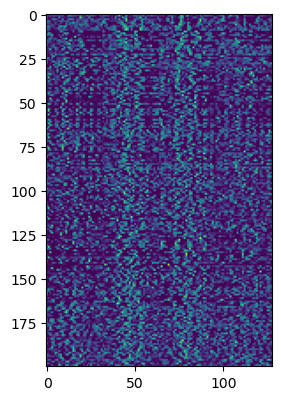

In [31]:
# Let's check your implementation
print(verify(test_get_SIFT_descriptors(get_SIFT_descriptors)))

from pa2_code.utils import cheat_interest_points

import time
start = time.time()
image1_features = get_SIFT_descriptors(image1_bw, X1, Y1)
image2_features = get_SIFT_descriptors(image2_bw, X2, Y2)
end = time.time()
duration = end - start
print(f'SIFT took {duration} sec.')

# visualize what the values of the first 200 SIFT feature vectors look like (should not be identical or all black)
plt.figure(); plt.subplot(1,2,1); plt.imshow(image1_features[:200])

196 matches from 2464 corners


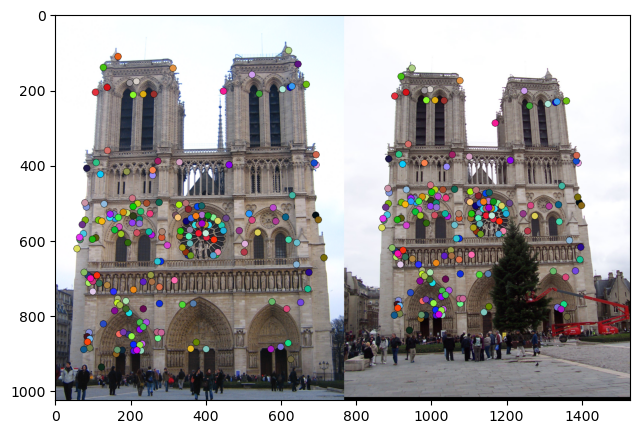

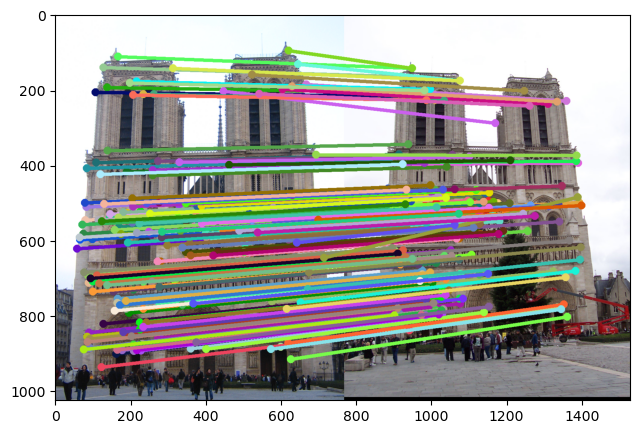

In [32]:
# Let's check the correspondences
from pa2_code.utils import show_correspondence_circles, show_correspondence_lines

matches, confidences = match_features_ratio_test(image1_features, image2_features)
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 200
c1 = show_correspondence_circles(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c1)
save_image('../results/vis_circles.jpg', c1)
c2 = show_correspondence_lines(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c2)
save_image('../results/vis_lines.jpg', c2)


You found 196/100 required matches
Accuracy = 0.933673


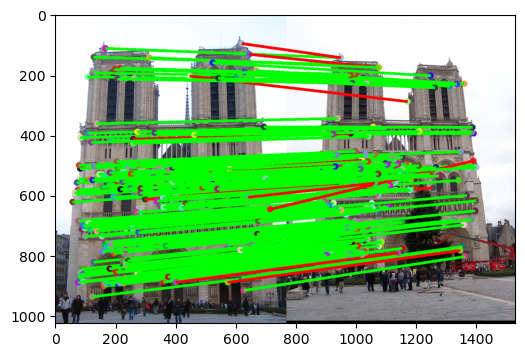

In [33]:
from pa2_code.utils import evaluate_correspondence
num_pts_to_evaluate = len(matches)
_, c = evaluate_correspondence(
    image1,
    image2,
    eval_file,
    scale_factor,
    X1[matches[:num_pts_to_evaluate, 0]],
    Y1[matches[:num_pts_to_evaluate, 0]],
    X2[matches[:num_pts_to_evaluate, 1]],
    Y2[matches[:num_pts_to_evaluate, 1]]
)
plt.figure(figsize=(8,4)); plt.imshow(c)
save_image('../results/eval.jpg', c)

In [34]:
# Your code runs in under 90 sec and achieves >80% acc on the Notre Dame pair
from pa2_unit_tests.test_part4_sift_descriptor import (
    test_feature_matching_speed,
    test_feature_matching_accuracy
)
print(
    'SIFT pipeline speed test:', 
    verify(test_feature_matching_speed(get_harris_interest_points, match_features_ratio_test, get_SIFT_descriptors))
)

print(
    'SIFT pipeline accuracy test:', 
    verify(test_feature_matching_accuracy(get_harris_interest_points, match_features_ratio_test, get_SIFT_descriptors))
)

196 matches from 2464 corners
Your Feature matching pipeline takes 23.56 seconds to run on Notre Dame
SIFT pipeline speed test: "Correct"
You found 196/100 required matches
Accuracy = 0.933673
Your Feature matching pipeline achieved 93.37% accuracy to run on Notre Dame
SIFT pipeline accuracy test: "Correct"


## Extra credit

<font size="4" color="Red">**1 (identical to 1.5.1): Performs the maxpooling operation without using PyTorch.**</font><br><br>
<font size="4" color="Red">**Note: to get the full credit, you need to get a function that takes a reasonable amount of time to run so that the TAs can verify your code works.**</font><br><br>

nms_maxpool():  "Correct"
Coordinates of local maxima:
	At 3,3, local maximum w/ confidence=7.00
	At 1,1, local maximum w/ confidence=6.00


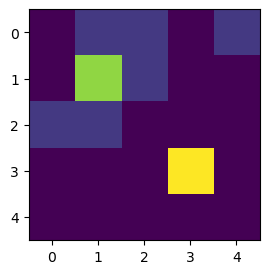

In [35]:
# assume your implementation is somewhere else
# Let's check your implementation
from pa2_unit_tests.test_part1_harris_corner import test_nms_maxpool
from pa2_code.utils import verify

print('nms_maxpool(): ', verify(test_nms_maxpool(nms_maxpool_no_pytorch)))

toy_response_map = np.array(
[
    [1,2,2,1,2],
    [1,6,2,1,1],
    [2,2,1,1,1],
    [1,1,1,7,1],
    [1,1,1,1,1]
]).astype(np.float32)
plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
plt.imshow(toy_response_map.astype(np.uint8))

# plt.subplot(1,2,2)
# maxpooled_image = nms_maxpool_numpy(toy_response_map, ksize=3)
# plt.imshow(maxpooled_image.astype(np.uint8))

x_coords, y_coords, confidences = nms_maxpool_no_pytorch(toy_response_map, k=2, ksize=3)
print('Coordinates of local maxima:')
for x, y, c in zip(x_coords, y_coords, confidences):
    print(f'\tAt {x},{y}, local maximum w/ confidence={c:.2f}')